<h1><center>
    Implementing, and using GNN architectures. <br/>
  
    
    Project 2
</center></h1>

Team: **Alvier**

 - **Siddhant Sahu** (20-744-579)
 - **Deborah Jakobi** (16-054-165)
 - **Francesco Tinner** (17-709-510)
 - **Mengqi Wang** (19-754-027)
 - **Tijana Kostovic** (16-720-443)

# Theory Question 1
<img src="https://i.stack.imgur.com/HIV6k.png" width="300">

Given the graph above with and without coloring, describe which underlying machine learning class the respective graph represents.


The image shows an undirected graph with five nodes. The graph is complete since every node is connected to every other node. This would result in a 5x5 adjacency matrix with ones everywhere except on the diagonal since the graph does not contain any self-loops. 


### **Graph *without* coloring** 
Considering both colors as part of the same graph means that all edges are connected to all other edges. This means it is a complete graph. The graph can be considered to have edges without labels, as well as nodes without labels. With it we can train a model to predict a whole graph or to predict links between nodes. Since we here also do not have any labeling of the nodes, we cannot make any predictions about nodes. The whole graph prediction may be formulated as a classification task of the graph.
The ML architecture for complete graphs when considering the Erlangen Programme for ML is the transformer. 

### **Graph *with* colouring**
If we look at the graph with coloring, we may assume that the coloring is sort of a label of the edges, in this case we have two different egde labels, namely blue and red. But still, the nodes are all black and no distinction between them is possible. But now there is a possibility to make predictions on the nodes. For this we need a way collect information from the edges and then pass the information to the nodes for prediction. 
If we would want to cluster red and blue edges we could apply spectral clustering. For predicting the links/edges we could use k-nearest neighbour classification. And surely we can also apply graph neural networks.
In the Erlangen Programm for ML, such a graph basically just corresponds to a 'normal' graph, where we can use GNN as the ML architecture. 




 




# Task 1.1
Given the graph shown in the image of theory question 1. Read in the graph and visualize your result, if your result does not match the geometry in the figure construct an isomorphism between the two graphs.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# graph with colouring
adjacency_matrix_wc = np.array([
                             [0, 2, 1, 1, 2],
                             [2, 0, 2, 1, 1],
                             [1, 2, 0, 2, 1],
                             [1, 1, 2, 0, 2],
                             [2, 1, 1, 2, 0]
])

# graph without colouring
adjacency_matrix_nc = np.array([
                             [0, 1, 1, 1, 1],
                             [1, 0, 1, 1, 1],
                             [1, 1, 0, 1, 1],
                             [1, 1, 1, 0, 1],
                             [1, 1, 1, 1, 0]
])

### **Graph *with* colouring**

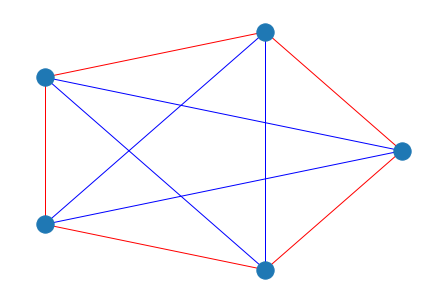

In [ ]:
nodes = 5

G = nx.Graph()
for i in range(nodes):
    for j in range(nodes):
        if i != j:
            if i==j+1 or i==j-1:
                G.add_edge(i,j, color='r')
            elif i==0 and j==4 or j==0 and i==4:
                G.add_edge(i,j, color='r')
            else:
                G.add_edge(i,j, color='b')

colors = [G[u][v]['color'] for u,v in G.edges()]
pos = nx.circular_layout(G) 

nx.draw(G, pos, edge_color=colors)

### **Graph *without* colouring**

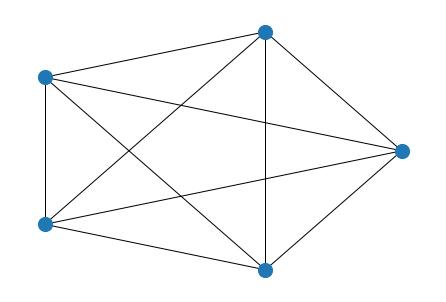

In [ ]:
rows, cols = np.where(adjacency_matrix_nc == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
pos = nx.circular_layout(gr)

nx.draw(gr, pos, node_size=200)
plt.show()

# Task 1.2
Given the graph shown in the image of theory question 1. Implement from scratch using <b>only numpy</b> both graph convolutions when respecting the coloring and without respecting the coloring.

This is our first implementation of this task. It follows exactly the slides on naive graph convolution. 

# Task 1.2.1
Graph Convolution without edge coloring.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(x))

In [ ]:
DIMENSION = 5
NUM_NODES = adjacency_matrix_nc.shape[0]

# initialize random emebddings for each node, embedding dim is 10 in this case
# we 'pretend' that each node has specific features that are encoded in the embedding
node_embeddings_X = np.random.uniform(-1, 1, size=(NUM_NODES, DIMENSION))

# initialize feature weights with R^{dxd}
feature_weights = np.random.uniform(-1, 1, size=(DIMENSION, DIMENSION))

node_matrix_X = []

# add all emebddings for one node where there is an edge in the adj matrix
for node in range(NUM_NODES):
    # create mask for all nodes that have an edge to current node
    neighbors = (adjacency_matrix_nc[node] == 1)
    # exclude the current node (in our case it does not matter as the nodes have no edges to itself, but that must not always be the case)
    neighbors[node] = False
    neighbor_embeddings = node_embeddings_X[neighbors]

    # create C matrix to weight neighbors
    weights_C = np.random.uniform(-1, 1, size=(node_embeddings_X[neighbors].shape))

    # apply function to neighbors
    weighted_features = np.dot(neighbor_embeddings, feature_weights)

    # apply one c vector to each neighbor to weight them individually
    weighted_neighbors = weights_C * weighted_features

    # sum over neighbors
    neighbor_sum = np.sum(weighted_neighbors, axis=0)

    # apply c weight and W weight to current node
    c_weight_curr_node = np.random.uniform(-1, 1, size=(node_embeddings_X[node].shape))
    weighted_curr_node = np.dot(c_weight_curr_node * node_embeddings_X[node], feature_weights)
    
    # add current node representation and neighbor node representation
    total_sum = weighted_curr_node + neighbor_sum

    node_matrix_X.append(total_sum)

# apply sigmoid
node_matrix_X = sigmoid(np.array(node_matrix_X))
node_matrix_X

array([[0.34216657, 0.2565119 , 0.68294515, 0.4660797 , 0.69139071],
       [0.44968294, 0.79511138, 0.30782215, 0.40885272, 0.39065219],
       [0.51024883, 0.81403554, 0.44296141, 0.7368647 , 0.23959803],
       [0.23557901, 0.07738795, 0.53187999, 0.59959811, 0.55547262],
       [0.43109451, 0.16456151, 0.8005302 , 0.43356845, 0.47062201]])

# Task 1.2.2
Graph Convolution with edge coloring.

In [ ]:
DIMENSION = 5
NUM_NODES = adjacency_matrix_wc.shape[0]
NUM_COLORS = 2

# initialize random emebddings for each node, embedding dim is 10 in this case
node_embeddings_X = np.random.uniform(-1, 1, size=(NUM_NODES, DIMENSION))

# initialize feature weights with R^{dxd}
feature_weights = np.random.uniform(-1, 1, size=(DIMENSION, DIMENSION))

node_matrix_X = []

# add all emebddings for one node where there is an edge in the adj matrix
for node in range(NUM_NODES):
    color_sum = np.zeros((DIMENSION,))

    # 0 represents no edge, 1 and above represent different colours
    for color in range(1, NUM_COLORS+1):
        # create mask for all nodes that have an edge to current node with respective color
        neighbors = (adjacency_matrix_wc[node] == color)
        
        # exclude the current node (in our case it does not matter as the nodes have no edges to itself, but that must not always be the case)
        neighbors[node] = False
        neighbor_embeddings = node_embeddings_X[neighbors]

        # create C matrix to weight neighbors, these weights are different for each color
        weights_C = np.random.uniform(-1, 1, size=(node_embeddings_X[neighbors].shape))

        # apply function to neighbors
        weighted_features = np.dot(neighbor_embeddings, feature_weights)

        # apply one c vector to each neighbor to weight them individually
        weighted_neighbors = weights_C * weighted_features

        # sum over neighbors of one color
        neighbor_sum = np.sum(weighted_neighbors, axis=0)

        color_sum += neighbor_sum
        
    # apply c weight and W weight to current node
    c_weight_curr_node = np.random.uniform(-1, 1, size=(node_embeddings_X[node].shape))
    weighted_curr_node = np.dot(c_weight_curr_node * node_embeddings_X[node], feature_weights)
    
    # add current node representation and neighbor node representation
    total_sum = weighted_curr_node + color_sum

    node_matrix_X.append(total_sum)

# apply sigmoid
node_matrix_X = sigmoid(np.array(node_matrix_X))
node_matrix_X

array([[0.28061742, 0.21589709, 0.24861813, 0.30049223, 0.37153252],
       [0.16769661, 0.67336249, 0.39036306, 0.3395424 , 0.35752356],
       [0.63367194, 0.30337402, 0.62901466, 0.63045679, 0.39358122],
       [0.65807339, 0.84204992, 0.52258184, 0.10597482, 0.44206199],
       [0.22867896, 0.24310294, 0.51703176, 0.38215462, 0.61686004]])

# Second way of solving 1.2

We also implemented a second, more neat way of graph convolution, namely by following these steps:

1. Normalizing adjacency matrix: $\hat{A} = \tilde{D}^{-1/2}\hat{A}\tilde{D}^{-1/2}$

2. Convolution: $H^{i+1} = W\hat{A}H^i$

3. Convolution with sigmoid activation: $H^{i+1} = \sigma(W\hat{A}H^i)$


For this part we assume that nodes depend on their edges, which would mean for a not-colored graph, every egde would be the same.

In [ ]:
adjacency_mat =  nx.to_numpy_matrix(G)

In [ ]:
# STEP 1 - normalization
from scipy.linalg import sqrtm 

adjacency_mat_mod = adjacency_mat + np.eye(G.number_of_nodes()) # the output of a node in a hidden layer should depend on itself and its neighbors
D_mod = np.zeros_like(adjacency_mat_mod)
np.fill_diagonal(D_mod, np.asarray(adjacency_mat_mod.sum(axis=1)).flatten())
D_mod_inverted = np.linalg.inv(sqrtm(D_mod))
adjacency_mat_hat = np.matmul(np.matmul(D_mod_inverted, adjacency_mat_mod), D_mod_inverted) # normalize to maintain scale of output feature vectors

In [ ]:
# STEP 2 & 3 - Graph Convolution
class GC():
    def __init__(self, n_input_feats, n_output_feats):
        self.n_input_feats = n_input_feats
        self.n_output_feats = n_output_feats
        self.W = np.random.uniform(-(1/np.sqrt(self.n_input_feats)), (1/np.sqrt(self.n_input_feats)), size=(self.n_input_feats, self.n_input_feats)) # random weights initialization with Xavier 

    def forward(self, adjacency_mat, X): # for first layer X is array of node embedding
        self._X = np.matmul(adjacency_mat, X).T # Each row contains features of a node (X is here H^i in markdown above)
        self.H = np.matmul(self.W, self._X) # output vector from last hidden layer 
        self.H = self.sigmoid(self.H)
        return self.H.T

    def sigmoid(self, x):
        return 1 / (1 + np.exp(x))

In [ ]:
# GC without coloring
gc = GC(G.number_of_nodes(), 1)
X = np.eye(G.number_of_nodes())
gc.forward(adjacency_mat_hat, X)

# here we see since the nodes in the not colored graph are not distinguishable, 
# since we cannot distinguish the edges and every node has two edges, we het the same result for every node.

matrix([[0.47029249, 0.53183009, 0.52793873, 0.50455783, 0.49208129],
        [0.47029249, 0.53183009, 0.52793873, 0.50455783, 0.49208129],
        [0.47029249, 0.53183009, 0.52793873, 0.50455783, 0.49208129],
        [0.47029249, 0.53183009, 0.52793873, 0.50455783, 0.49208129],
        [0.47029249, 0.53183009, 0.52793873, 0.50455783, 0.49208129]])

In the graph with edge coloring we can assume that the two colors are labels or weights on the edges. The graph convolution must be adapted to take different types of edges into account and therefore have different type of message passing steps.

In [ ]:
# assign weights to the colored edges. Red=1 and blue=2
colors_to_weights = []
for i, c in enumerate(colors):
    if c == 'r':
        colors_to_weights.append(1)
    else:
        colors_to_weights.append(2)

weights = {}
counter = 0
for e in G.edges():
    weights[e] = colors_to_weights[counter]
    counter += 1

# add weights to edges for distinction
nx.set_edge_attributes(G, values=weights, name='weight')
weighted_adjacency_mat =  nx.to_numpy_matrix(G)
weighted_adjacency_mat

matrix([[0., 1., 2., 2., 1.],
        [1., 0., 1., 2., 2.],
        [2., 1., 0., 1., 2.],
        [2., 2., 1., 0., 1.],
        [1., 2., 2., 1., 0.]])

In [ ]:
# Do the same normalization step as above
from scipy.linalg import sqrtm 

weighted_adjacency_mat_mod = weighted_adjacency_mat + np.eye(G.number_of_nodes()) # all nodes should be self-connected, then utput of a node in a hidden layer depends on itself and its neighbors
D_mod = np.zeros_like(weighted_adjacency_mat_mod)
np.fill_diagonal(D_mod, np.asarray(weighted_adjacency_mat_mod.sum(axis=1)).flatten())
D_mod_inverted = np.linalg.inv(sqrtm(D_mod))
weighted_adjacency_mat_hat = np.matmul(np.matmul(D_mod_inverted, weighted_adjacency_mat_mod), D_mod_inverted) # normalize to maintain scale of output feature vectors

In [ ]:
# GC with coloring
gc = GC(G.number_of_nodes(), 2)
X = np.eye(G.number_of_nodes())
gc.forward(weighted_adjacency_mat_hat, X)

matrix([[0.5033409 , 0.51666838, 0.46691964, 0.47796141, 0.44059918],
        [0.49397987, 0.51425448, 0.47361622, 0.49970603, 0.4656317 ],
        [0.46713432, 0.52453854, 0.47262032, 0.49274701, 0.4692019 ],
        [0.45964189, 0.50331659, 0.46157182, 0.48896541, 0.45166094],
        [0.47535617, 0.51466487, 0.4710002 , 0.49247133, 0.44323086]])

# Task 2

We will now reinterpret the exercise that we had in the last assignment.

In the following, we want to train a GNN using the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl) using the data set from last week  ([Tensorflow version](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) and [(py)torch version](https://pytorch.org/text/stable/datasets.html#yelpreviewpolarity).

Recap:
Given the text of a review, we want to determine whether the yelp review is positive and negative. The data set is pre-split into training and test set. Please use the training data to fine-tune your model, while using the test data to evaluate your models performance. This exercise does not necessarily end in having a SOTA model, the goal is for you to use and fine-tune SOTA pretrained large language models.

Problem Setting:

The label $y$ to a Yelp review $T$ is either positive or negative. Given a Yelp Review $T$ and a polarity feedback $y$ determine whether the Review $T$ is positive or negative. The training set $\mathcal{D} = \{(T_1, y_1), \ldots, (T_N, y_N)\}$, where $T_i$ is review $i$ and $y_i$ is $T_i$'s polarity feedback. Use <b>AUC</b> as Evaluation Metric.

In the following, please solve all subtasks as well as the .

## Theory Question 2
Name two different ways of estimating the empirical risk. Discuss bias and variance of two different <b>Evaluation Protocols</b>. Implement one of the two evaluation protocols for the problem below.

### Empirical risk estimation
To estimate the empirical risk we can pick any loss function and any model and average over the loss of the model on a (test) dataset. E.g cross-entropy loss of a GCN or we could use the hinge loss on an MLP. This way we can estimate the empirical risk (i.e. how well the model actually performs in practice) because we cannot compute the actual risk.

### Evaluation protocol 1: hold-out validation
One way of evaluating the performance of a classifier is to randomly split the data into three sets. The training split is the largest split of around 80% of the entire dataset. The validation and test set are around 10% of the dataset. The test set can also be referred to as hold-out set. During the training phase, the model will be trained on the training set only. To test the model's performance during training only the validation set will be used. Using a validation set makes it possible to test differet hyperparameters which might be useful for neural models. Also, this way we can prevent the model from overfitting or at least we would notice if it does. The final evalution of the model will be done on the test set.

As the model has never seen the test set, there will be no bias. The variance of this protocol can be very high as the training data will always be the same and the test data could be very different from the training data. Also if the entire dataset is very small, then the test and validation set could be too small to properly evaluate the model. This can lead to high variance.

### Evaluation protocol 2: $k$-fold validation
The data is split into training and validation set as well. This time, there is no fixed split but the data will be randomly split $k$ times such that there are different combinations of training and validation sets. For each of the k splits, the model will be trained on the training set and evaluated on the validation set. Instead of just evaluating the model on one validation set, we can average over the evaluation of the $k$ validation evaluations. We report another evaluation on the yelp test set. This protocl is suited for small datasets and as we do not use the entire dataset, it makes sense to use this protocol.

As we use different train-validation splits, the bias of the model should be low. Again, the model cannot see the validation set during training. For this protocol, the variance is lower, as the model will be trained on different training sets and we average the loss of the validation set. 


## Task 2.0
Load the Yelp Review Polarity dataset. Here it is also possible to only use part of the data (e.g. 5%)

In [ ]:
!pip install datasets
!pip install dgl

     |████████████████████████████████| 342 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 45.1 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
     |████████████████████████████████| 136 kB 44.0 MB/s 
     |████████████████████████████████| 77 kB 4.6 MB/s 
     |████████████████████████████████| 127 kB 13.5 MB/s 
     |████████████████████████████████| 144 kB 47.8 MB/s 
     |████████████████████████████████| 271 kB 48.6 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive/')

# Imports
import numpy as np
from datasets import load_dataset
import spacy
import torch
import torch.nn.functional as F

import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
# run the following download model line only once and restart runtime to load model
!python -m spacy download en_core_web_md

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Using backend: pytorch


     |████████████████████████████████| 96.4 MB 3.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
yelp_train = load_dataset("yelp_polarity", split='train[:1000]') 

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61. Subsequent calls will reuse this data.


## Task 2.1
Reinterpret the text data as graph data using DGL.

In [ ]:
class yelpDataset(DGLDataset):
    def __init__(self, text_data, embed_model):
        self.data = text_data
        self.embed_model = embed_model
        super().__init__(name='yelp') 

    def process(self):
        self.graphs = []
        self.labels = []

        # Create a graph for each sentence
        for data in self.data:
            label, text = data['label'], data['text']
            # embed sentence
            word_embeds = self.embed_model(text)
            num_nodes = len(word_embeds)
            # connect words in linear order
            src = np.arange(start=0, stop=num_nodes-1)
            dst = np.arange(start=1, stop=num_nodes)

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes = num_nodes)
            g.ndata['feat'] = torch.from_numpy(np.array([word.vector for word in word_embeds]))
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

# load the downloaded pretrained model for word embeddings
nlp = spacy.load("en_core_web_md")
train_dataset = yelpDataset(text_data = yelp_train, embed_model = nlp)
train_dataloader = GraphDataLoader(train_dataset, batch_size=64, drop_last=False)
graph, label = train_dataset[0]
print(graph, label)

Graph(num_nodes=140, num_edges=139,
      ndata_schemes={'feat': Scheme(shape=(300,), dtype=torch.float32)}
      edata_schemes={}) tensor(0)


## Task 2.2

Split the data according to your evaluation protocol. Explain whether this task is inductive or transductive.

The task is inductive since we built a predictive model for graph classification, and the testset is independent and entirely unseen by the model during training. Since we are not deriving anything from the training or validation set while testing and vice versa, we think the learning is inductive rather than transductive.

In [ ]:
yelp_test = load_dataset("yelp_polarity", split='test[-200:]') 
test_dataset = yelpDataset(text_data = yelp_test, embed_model = nlp)
test_dataloader = GraphDataLoader(test_dataset, batch_size=64, drop_last=False)

Reusing dataset yelp_polarity (/root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61)


## Task 2.3
Implement, evaluate (with the evaluation protocol you defined in Theory Question 2) and train a GCN architecture for the Yelp data set and the problem setting defined above.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes, allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [ ]:
import random
class Subset(object):
    """Subset of a dataset at specified indices
    Code adapted from PyTorch.

    Parameters
    ----------
    dataset
        dataset[i] should return the ith datapoint
    indices : list
        List of datapoint indices to construct the subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, item):
        """Get the datapoint indexed by item

        Returns
        -------
        tuple
            datapoint
        """
        return self.dataset[self.indices[item]]

    def __len__(self):
        """Get subset size

        Returns
        -------
        int
            Number of datapoints in the subset
        """
        return len(self.indices)


def k_fold_split(dataset, k, shuffle=True):
    """
    Parameters
    -----------
    dataset
        An instance for the Dataset class defined above.
    k: int
        The number of folds.
    shuffle: bool
        Whether to shuffle the dataset before performing a k-fold split.

    Returns
    --------
    list of length k
        Each element is a tuple (train_set, val_set) corresponding to a fold.
    """
    assert k >= 2, 'Expect the number of folds to be no smaller than 2, got {:d}'.format(k)
    all_folds = []
    indices = list(range(len(dataset)))
    if shuffle:
        random.shuffle(indices)
    frac_per_part = 1. / k
    data_size = len(dataset)
    for i in range(k):
        val_start = int(data_size * i * frac_per_part)
        val_end = int(data_size * (i + 1) * frac_per_part)
        val_indices = indices[val_start: val_end]
        val_subset = Subset(dataset,  val_indices)
        train_indices = indices[:val_start] + indices[val_end:]
        train_subset = Subset(dataset,  train_indices)
        all_folds.append((train_subset, val_subset))
    return all_folds

In [ ]:
# Create the model with given dimensions
model = GCN(in_feats = 300, h_feats = 256, num_classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
k = 5
for epoch in range(10):
    acc = 0
    for fold in k_fold_split(train_dataset, k, shuffle=True):
      train_dataloader = GraphDataLoader(fold[0], batch_size=64, drop_last=False)
      val_dataloader = GraphDataLoader(fold[1], batch_size=64, drop_last=False)

      for batched_graph, labels in train_dataloader:
          pred = model(batched_graph, batched_graph.ndata['feat'].float())
          loss = F.cross_entropy(pred, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      num_correct = 0
      num_tests = 0
      with torch.no_grad():
        for batched_graph, labels in val_dataloader:
            pred = model(batched_graph, batched_graph.ndata['feat'].float())
            val_loss = F.cross_entropy(pred, labels)
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        acc += num_correct / num_tests
    print('Epoch %d | Train Loss: %.3f | K-Folds Validation loss: %.3f, accuracy: %.1f%%' % (epoch, loss.item(), val_loss.item(), acc*100/k))

Epoch 0 | Train Loss: 0.122 | K-Folds Validation loss: 0.065, accuracy: 79.5%
Epoch 1 | Train Loss: 0.223 | K-Folds Validation loss: 0.053, accuracy: 91.9%
Epoch 2 | Train Loss: 0.105 | K-Folds Validation loss: 0.090, accuracy: 94.7%
Epoch 3 | Train Loss: 0.047 | K-Folds Validation loss: 0.043, accuracy: 95.9%
Epoch 4 | Train Loss: 0.021 | K-Folds Validation loss: 0.012, accuracy: 99.1%
Epoch 5 | Train Loss: 0.025 | K-Folds Validation loss: 0.005, accuracy: 99.7%
Epoch 6 | Train Loss: 0.007 | K-Folds Validation loss: 0.010, accuracy: 99.8%
Epoch 7 | Train Loss: 0.011 | K-Folds Validation loss: 0.009, accuracy: 99.8%
Epoch 8 | Train Loss: 0.025 | K-Folds Validation loss: 0.077, accuracy: 99.7%
Epoch 9 | Train Loss: 0.023 | K-Folds Validation loss: 0.003, accuracy: 99.8%


In [ ]:
num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['feat'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.92


# Task 3
In the following,  we will use a dataset as well as pre-defined task. You can find the dataset as well as the task under ogbl-collab [here](https://ogb.stanford.edu/docs/linkprop/#ogbl-collab). Split the data, use their evaluation metric as well as train a GCN for link prediction. 

In [ ]:
import torch
!pip install torch-sparse torch-geometric torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install ogb 

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 407 kB 5.3 MB/s 
     |████████████████████████████████| 7.9 MB 38.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=f7fe78251a980c4eae3f0a58cb5dccd35dde9a055b0565108439a6fc99177be9
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 78 kB 3.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=28a8f604f6210278ab5ee5a74211f1af4e91d13039decf3e763ad54ad571ee0a
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [ ]:
from ogb.linkproppred.dataset_pyg import PygLinkPropPredDataset
from ogb.linkproppred import Evaluator

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch_sparse import SparseTensor
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

# Task 3.1
Load and split the data.


In [ ]:
dataset = PygLinkPropPredDataset(name = "ogbl-collab") 
data = dataset[0] # pyg graph object
edge_index = data.edge_index

data.edge_weight = data.edge_weight.view(-1).to(torch.float)
data = T.ToSparseTensor()(data)
split_edge = dataset.get_edge_split()

# use training + validation edges for inference on test set
val_edge_index = split_edge['valid']['edge'].t()
full_edge_index = torch.cat([edge_index, val_edge_index], dim=-1)
data.full_adj_t = SparseTensor.from_edge_index(full_edge_index).t()
data.full_adj_t = data.full_adj_t.to_symmetric()

Downloaded 0.11 GB: 100%|██████████| 117/117 [00:03<00:00, 30.46it/s]


Extracting dataset/collab.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 4624.37it/s]

Saving...



Done!


In [ ]:
data

Data(num_nodes=235868, x=[235868, 128], edge_year=[2358104, 1], adj_t=[235868, 235868, nnz=2358104], full_adj_t=[235868, 235868, nnz=1999288])

# Task 3.2
Implement, train and evaluate using the data (from Task 3.1.) a GCN using the edge and node information in a geometric DL package of your choice.

## Implementation
References: 

https://arxiv.org/pdf/1609.02907,

https://github.com/snap-stanford/ogb/tree/master/examples/linkproppred/collab




In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

In [ ]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [ ]:
def train(model, predictor, data, split_edge, optimizer, batch_size):
    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(data.x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(data.x, data.adj_t)

        edge = pos_train_edge[perm].t()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        edge = torch.randint(0, data.num_nodes, edge.size(), dtype=torch.long,
                             device=h.device)
        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

In [ ]:
@torch.no_grad()
def test(model, predictor, data, split_edge, evaluator, batch_size, K_thresholds):
    model.eval()
    predictor.eval()

    h = model(data.x, data.adj_t)

    pos_train_edge = split_edge['train']['edge'].to(h.device)
    pos_valid_edge = split_edge['valid']['edge'].to(h.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(h.device)
    pos_test_edge = split_edge['test']['edge'].to(h.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(h.device)

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    h = model(data.x, data.full_adj_t)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in K_thresholds:
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results


## Settings 

In [ ]:
# SETTINGS
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
hidden_channels = 256
num_layers = 3
dropout = 0.0
lr = 1e-3
epochs = 400
batch_size = 64*1024
eval_steps = 5 # eval every n epoch
log_steps = 5
K_thresholds= [50] # we set threshold K to 50 as recommended

## Procedure for Training, Validation, and Testing

In [ ]:
data = data.to(device)

model = GCN(data.num_features, hidden_channels,
            hidden_channels, num_layers,
            dropout).to(device)

predictor = LinkPredictor(hidden_channels, hidden_channels, 1,
                          num_layers, dropout).to(device)

evaluator = Evaluator(name='ogbl-collab')

optimizer = torch.optim.Adam(
            list(model.parameters()) + list(predictor.parameters()),
            lr=lr)

for epoch in range(1, 1 + epochs):
  loss = train(model, predictor, data, split_edge, optimizer,
                batch_size)

  if epoch % eval_steps == 0:
      results = test(model, predictor, data, split_edge, evaluator,
                      batch_size, K_thresholds=K_thresholds)

      if epoch % log_steps == 0:
          for key, result in results.items():
              train_hits, valid_hits, test_hits = result
              print(key)
              print(f'Epoch: {epoch:02d}, '
                    f'Loss: {loss:.4f}, '
                    f'Train: {100 * train_hits:.2f}%, '
                    f'Valid: {100 * valid_hits:.2f}%, '
                    f'Test: {100 * test_hits:.2f}%')

Hits@50
Epoch: 05, Loss: 0.4768, Train: 13.61%, Valid: 14.41%, Test: 13.44%
Hits@50
Epoch: 10, Loss: 0.3001, Train: 20.32%, Valid: 20.02%, Test: 18.45%
Hits@50
Epoch: 15, Loss: 0.1978, Train: 36.79%, Valid: 29.80%, Test: 26.41%
Hits@50
Epoch: 20, Loss: 0.1709, Train: 38.04%, Valid: 30.25%, Test: 26.98%
Hits@50
Epoch: 25, Loss: 0.1456, Train: 52.55%, Valid: 37.38%, Test: 32.49%
Hits@50
Epoch: 30, Loss: 0.1318, Train: 54.92%, Valid: 37.45%, Test: 32.48%
Hits@50
Epoch: 35, Loss: 0.1099, Train: 57.10%, Valid: 38.57%, Test: 33.26%
Hits@50
Epoch: 40, Loss: 0.1010, Train: 61.29%, Valid: 40.53%, Test: 34.52%
Hits@50
Epoch: 45, Loss: 0.0947, Train: 60.99%, Valid: 40.22%, Test: 34.43%
Hits@50
Epoch: 50, Loss: 0.1112, Train: 62.32%, Valid: 41.17%, Test: 35.62%
Hits@50
Epoch: 55, Loss: 0.0857, Train: 66.82%, Valid: 42.94%, Test: 36.31%
Hits@50
Epoch: 60, Loss: 0.0793, Train: 68.11%, Valid: 43.20%, Test: 36.72%
Hits@50
Epoch: 65, Loss: 0.0824, Train: 68.22%, Valid: 42.26%, Test: 35.59%
Hits@50
Epoc

# Task 4
Please describe your team's implementation of this project, including your personal contribution, in 1000-1500 characters. Each team member must explain the main aspects of the team's implementation, and may not discuss this summary with other students. You are allowed to use figures and tables to clarify. This summary constitutes a separately and individually graded piece of work.